### aim: this runset: https://www.notion.so/2025-10-AMOC-runset-281f73b11e7e80f68e18dd2249288be7

- check that we are outputting everything we need
- helpful LimitsOfPhytoplankton/LoP-AMOC-May2025/biomass-vs-ppt.ipynb



In [46]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [47]:
# ==== Core scientific packages ====
import os
import sys
import glob
import time
from datetime import datetime
from importlib import reload

import numpy as np
import pandas as pd
import xarray as xr
import netCDF4 as nc

# ==== Plotting & visualization ====
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Rectangle
import matplotlib.path as mpath

import cartopy as cp
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cmocean import cm

# ==== Environment / display ====
%matplotlib inline

# ==== Custom utilities ====
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import snippets as sp
reload(sp)


<module 'snippets' from '/gpfs/home/mep22dku/scratch/SOZONE/UTILS/snippets.py'>

In [48]:
import helpfxn as hf
reload(hf)
print([item for item in dir(hf) if not item.startswith('_')])


['get_dominant_species', 'glob', 'integrate_and_identify_dominant_phytoplankton', 'integrate_and_identify_dominant_ppt', 'make_yearlist', 'np', 'xr']


## set fonts and colormap 

In [49]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams
import os

# ================================
# FONT CONFIGURATION
# ================================

# Disable LaTeX (so mathtext uses chosen font)
plt.rcParams['text.usetex'] = False

# Set base font size
fs = 11
rcParams.update({
    'font.size': fs,
    'axes.titlesize': fs,
    'axes.labelsize': fs,
    'xtick.labelsize': fs,
    'ytick.labelsize': fs,
    'legend.fontsize': fs,
})

# Path to Gill Sans
gill_sans_path = "/gpfs/home/mep22dku/scratch/FONTS/gill-sans/GillSansMedium.otf"

# Try to load it
if os.path.exists(gill_sans_path):
    font_manager.fontManager.addfont(gill_sans_path)
    gill_font_name = font_manager.FontProperties(fname=gill_sans_path).get_name()
    chosen_font = gill_font_name
    print(f"✅ Using custom font: {gill_font_name}")
else:
    chosen_font = "DejaVu Sans"
    print("⚠️ Gill Sans not found, using fallback: DejaVu Sans")

# Apply globally
rcParams['font.family'] = chosen_font
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = chosen_font
rcParams['mathtext.it'] = chosen_font
rcParams['mathtext.bf'] = chosen_font

#czechoslovak railways
colors = ['#2B5F7E', '#7A9B5C', '#A8B8C4', '#D4B85A', '#8B6F47', '#3F5F3C']
# metro:
# colors = [
#     '#de4231',  # DIA - red
#     '#01529b',  # MIX - dark blue
#     '#6db8ff',  # COC - light blue
#     '#808080',  # PIC - grey
#     '#02954f',  # PHA - green
#     '#f3c108'   # FIX - yellow
# ]

✅ Using custom font: Gill Sans


## plots to make:

- how does the AMOC look?
- for a period of 10 years (avg), make a map of dominant phytoplankton
- make a map of the region where the colourblocks are replaced by lines

## projected map with region boundaries

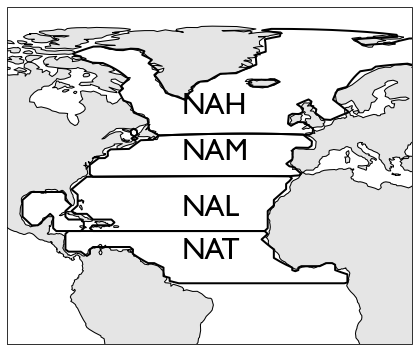

In [50]:
atl = xr.open_dataset('/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/data/meshmask_with_Atl.nc')
    
regs = ['NAT', 'NAL', 'NAM', 'NAH']#, 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5']

regdict = {'NAT' : {'number' : 1},
           'NAL' : {'number': 2},
          'NAM' : {'number': 3},
           'NAH' : {'number': 4},
          }

maskno = np.zeros([149,182])
for i in range(0, len(regs)):
    maskno[atl[regs[i]][0,0,:,:] == 1] = regdict[regs[i]]['number']
maskno[maskno == 0] = np.nan

fact = 0.5
tfig = plt.figure(figsize=[14.5*fact, 14.5*fact])
ax = plt.axes(projection=ccrs.PlateCarree())

year = 1984
tgrid = xr.open_dataset(f'/gpfs/data/greenocean/software/runs/TOM12_TJ_RVA0/ORCA2_1m_{year}0101_{year}1231_ptrc_T.nc')

nav_lon = tgrid['nav_lon'].values
nav_lat = tgrid['nav_lat'].values
ax.coastlines(zorder = 1 )
#lons, lats extent
ax.set_extent([ -102, 30, -20, 120,], crs=ccrs.PlateCarree())

ax.add_feature(cp.feature.LAND, color='grey', alpha = 0.2)

fs = 30
ax.text(-45, 8, s = 'NAT', color='k', 
        fontsize = fs, fontweight = 'bold', transform=ccrs.PlateCarree())
ax.text(-45, 22, s = 'NAL', color='k', 
        fontsize = fs, fontweight = 'bold', transform=ccrs.PlateCarree())
ax.text(-45, 40, s = 'NAM', color='k', 
        fontsize = fs, fontweight = 'bold', transform=ccrs.PlateCarree())
ax.text(-45, 55, s = 'NAH', color='k', 
        fontsize = fs, fontweight = 'bold', transform=ccrs.PlateCarree())

for region_num in [1, 2, 3, 4]:
    mask_single = np.where(maskno == region_num, 1, 0)
    ax.contour(nav_lon, nav_lat, mask_single, levels=[0.5], 
               colors='black', linewidths=2, transform=ccrs.PlateCarree(), zorder=1)
    


## dominant phytoplankton map


### get out dominant ppt/phy groups for spring/summer 1950-1959

In [51]:
tmod = 'TOM12_TJ_LA50'; yrs = 1950; yre = 1959
ex = False
if ex:
    reload(hf)
    ptrc = hf.make_yearlist(yrs,yre,'ptrc','TOM12_TJ_LA50')
    tptrc = xr.open_mfdataset(ptrc)

    diad = hf.make_yearlist(yrs,yre,'diad','TOM12_TJ_LA50')
    tdiad = xr.open_mfdataset(diad)


    tdiad = tdiad[['PPT_DIA', 'PPT_MIX', 'PPT_COC', 'PPT_PIC','PPT_PHA', 'PPT_FIX']]
    tptrc = tptrc[['DIA', 'MIX', 'COC', 'PIC','PHA', 'FIX']]

    tdiad_spring = tdiad.sel(time_counter=tdiad['time_counter.season'] == 'MAM').mean('time_counter')
    
    ##############
    tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
    # Get vertical grid spacing and rename dimensions
    e3t = tmesh['e3t_0'].rename({'t': 'time_counter', 'z': 'deptht'})

    # Remove time dimension if it exists (mesh is time-invariant)
    if 'time_counter' in e3t.dims:
        e3t = e3t.squeeze('time_counter', drop=True)

    # Broadcast e3t to match ptrcc_spring dimensions
    e3t_broadcasted = e3t.broadcast_like(tdiad_spring)

    tmask = tmesh.tmaskutil.squeeze('t', drop=True) if 't' in tmesh.tmaskutil.dims else tmesh.tmaskutil


    tdiad_summer = tdiad.sel(time_counter=tdiad['time_counter.season'] == 'JJA').mean('time_counter')
    tdiad_spring_int = (tdiad_spring * e3t_broadcasted).sum(dim='deptht')
    tdiad_summer_int = (tdiad_summer * e3t_broadcasted).sum(dim='deptht')
    tdiad_spring_int = hf.get_dominant_species(tdiad_spring_int)
    tdiad_summer_int = hf.get_dominant_species(tdiad_summer_int)

    tptrc_spring = tptrc.sel(time_counter=tptrc['time_counter.season'] == 'MAM').mean('time_counter')
    tptrc_summer = tptrc.sel(time_counter=tptrc['time_counter.season'] == 'JJA').mean('time_counter')
    tptrc_spring_int = (tptrc_spring * e3t_broadcasted).sum(dim='deptht')
    tptrc_summer_int = (tptrc_summer * e3t_broadcasted).sum(dim='deptht')
    tptrc_spring_int = hf.get_dominant_species(tptrc_spring_int)
    tptrc_summer_int = hf.get_dominant_species(tptrc_summer_int)
    
    tptrc_spring_int.to_netcdf(f'./data/{tmod}-MAM-PHY-{yrs}-{yre}.nc')
    tdiad_spring_int.to_netcdf(f'./data/{tmod}-MAM-PPT-{yrs}-{yre}.nc')
    tptrc_summer_int.to_netcdf(f'./data/{tmod}-JJA-PHY-{yrs}-{yre}.nc')
    tdiad_summer_int.to_netcdf(f'./data/{tmod}-JJA-PPT-{yrs}-{yre}.nc')

In [52]:
tptrc_spring_int = xr.open_dataset('./data/TOM12_TJ_LA50-MAM-PHY-1950-1959.nc')
tdiad_spring_int = xr.open_dataset('./data/TOM12_TJ_LA50-MAM-PPT-1950-1959.nc')
tptrc_summer_int = xr.open_dataset('./data/TOM12_TJ_LA50-JJA-PHY-1950-1959.nc')
tdiad_summer_int = xr.open_dataset('./data/TOM12_TJ_LA50-JJA-PPT-1950-1959.nc')

## trying to regrid from within jn

- ok we have failed at this, just do it with a shell script:

    (swamp2) [mep22dku@hali-login01 ~/scratch/AMOC-PLANKTOM/AMOC-LoP-202510]$ bash rg.sh

## global map

In [53]:
tmesh = xr.open_dataset('/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/data/meshmask_with_Atl.nc')

Figure saved to: ./plts/TOM12_TJ_LA50-dominant_species-GLOBAL.png


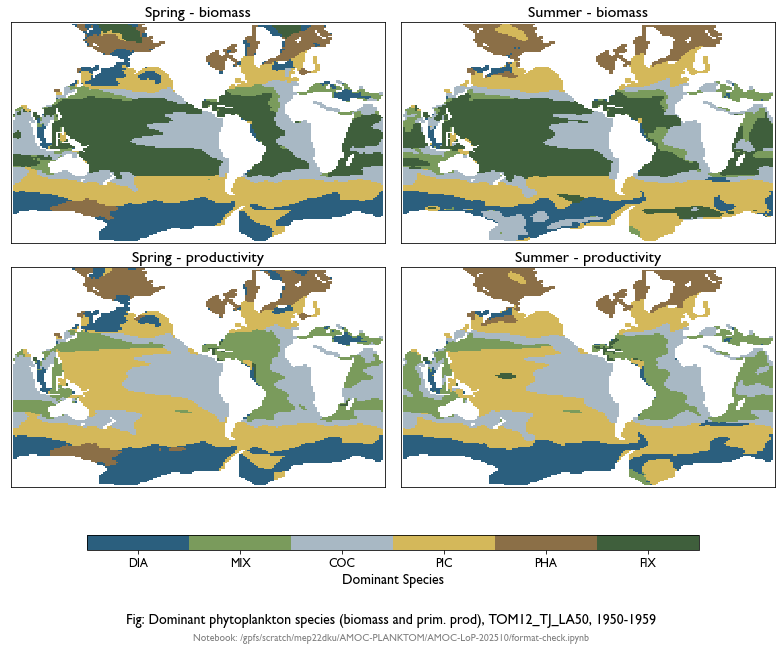

In [54]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np
import os

# ============ SETTINGS ============
# Set axis ranges here (zoom control)
X_MIN = None  # Set to None for full range, or specify value (e.g., 0)
X_MAX = None  # Set to None for full range, or specify value (e.g., 100)
Y_MIN = None  # Set to None for full range, or specify value (e.g., 0)
Y_MAX = None  # Set to None for full range, or specify value (e.g., 100)

# Figure description
FIG_DESCRIPTION = "Fig: Dominant phytoplankton species (biomass and prim. prod), TOM12_TJ_LA50, 1950-1959"
SHOW_NOTEBOOK_PATH = True  # Set to False to hide notebook path
NOTEBOOK_NAME = "format-check.ipynb"  # Manually set your notebook name here
OUTPUT_NAM = 'TOM12_TJ_LA50-dominant_species-GLOBAL.png'
# Output directory
OUTPUT_DIR = "./plts"

# ===== LAYOUT PARAMETERS (adjust these!) =====
FIGURE_WIDTH = 11          # Width of figure in inches
FIGURE_HEIGHT = 9         # Height of figure in inches (increase to reduce vertical squishing)
TITLE_FONTSIZE = 16        # Font size for subplot titles
COLORBAR_LABEL_FONTSIZE = 14   # Font size for colorbar label
COLORBAR_TICK_FONTSIZE = 12    # Font size for colorbar tick labels
DESCRIPTION_FONTSIZE = 14      # Font size for figure description
PATH_FONTSIZE = 10             # Font size for notebook path
DESCRIPTION_Y_POSITION = 0.03  # Vertical position of description (0=bottom, 1=top)
PATH_Y_POSITION = 0.004        # Vertical position of path (below description)
TIGHT_LAYOUT_BOTTOM = 0.002     # Bottom margin for tight_layout (increase to add space for description)
COLORBAR_PAD = 0.08            # Space between plots and colorbar
# ============================================
# ==================================

# Get current directory path
notebook_path = os.path.abspath(os.getcwd())

# Combine path and name
full_notebook_path = os.path.join(notebook_path, NOTEBOOK_NAME)

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

# List of your 4 xarrays
datasets = [tptrc_spring_int, tptrc_summer_int, tdiad_spring_int, tdiad_summer_int]
titles = ['Spring - biomass', 'Summer - biomass', 'Spring - productivity', 'Summer - productivity']

# Apply mask
tmask = tmesh.tmaskutil.squeeze('t', drop=True) if 't' in tmesh.tmaskutil.dims else tmesh.tmaskutil

# Custom colors for the 6 species
cmap = ListedColormap(colors)
bounds = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]
norm = BoundaryNorm(bounds, cmap.N)

fig, axes = plt.subplots(2, 2, figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))
axes = axes.flatten()

for i, (ax, data, title) in enumerate(zip(axes, datasets, titles)):
    masked_dominant = data.dominant_species.where(tmask == 1)
    im = ax.pcolormesh(masked_dominant, cmap=cmap, norm=norm)
    ax.set_title(title, fontsize=TITLE_FONTSIZE)
    
    # Remove axis ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Set axis ranges if specified
    if X_MIN is not None or X_MAX is not None:
        ax.set_xlim(X_MIN, X_MAX)
    if Y_MIN is not None or Y_MAX is not None:
        ax.set_ylim(Y_MIN, Y_MAX)

# Add shared colorbar with more padding and bigger font
plt.tight_layout(rect=[0, TIGHT_LAYOUT_BOTTOM, 1, 1])
cbar = fig.colorbar(im, ax=axes, orientation='horizontal', pad=COLORBAR_PAD, aspect=40, shrink=0.8)
cbar.set_ticks([1, 2, 3, 4, 5, 6])
cbar.set_ticklabels(['DIA', 'MIX', 'COC', 'PIC', 'PHA', 'FIX'], fontsize=COLORBAR_TICK_FONTSIZE)
cbar.set_label('Dominant Species', fontsize=COLORBAR_LABEL_FONTSIZE)

# Add figure description at the bottom
fig.text(0.5, DESCRIPTION_Y_POSITION, FIG_DESCRIPTION, ha='center', fontsize=DESCRIPTION_FONTSIZE, style='italic')

# Add notebook path if enabled
if SHOW_NOTEBOOK_PATH:
    fig.text(0.5, PATH_Y_POSITION, f'Notebook: {full_notebook_path}', ha='center', fontsize=PATH_FONTSIZE, 
             style='italic', color='gray')

# Save figure
output_path = os.path.join(OUTPUT_DIR, OUTPUT_NAM)
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"Figure saved to: {output_path}")

plt.show()


## atlantic map

Figure saved to: ./plts/TOM12_TJ_LA50-dominant_species-ATL.png


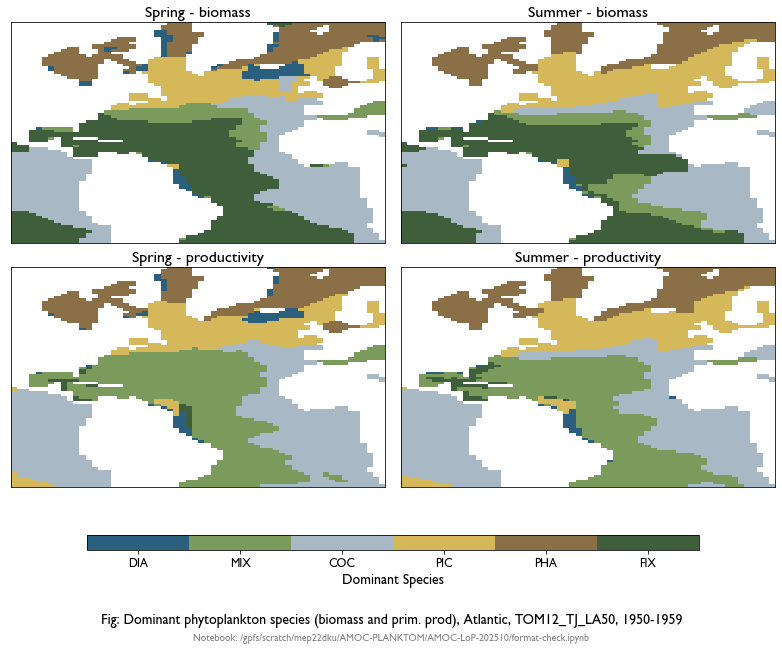

In [55]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np
import os

# ============ SETTINGS ============
# Set axis ranges here (zoom control)
X_MIN = 90  # Set to None for full range, or specify value (e.g., 0)
X_MAX = 150  # Set to None for full range, or specify value (e.g., 100)
Y_MIN = 50  # Set to None for full range, or specify value (e.g., 0)
Y_MAX = 140  # Set to None for full range, or specify value (e.g., 100)

# Figure description
FIG_DESCRIPTION = "Fig: Dominant phytoplankton species (biomass and prim. prod), Atlantic, TOM12_TJ_LA50, 1950-1959"
SHOW_NOTEBOOK_PATH = True  # Set to False to hide notebook path
NOTEBOOK_NAME = "format-check.ipynb"  # Manually set your notebook name here
OUTPUT_NAM = 'TOM12_TJ_LA50-dominant_species-ATL.png'
# Output directory
OUTPUT_DIR = "./plts"

# ===== LAYOUT PARAMETERS (adjust these!) =====
FIGURE_WIDTH = 11          # Width of figure in inches
FIGURE_HEIGHT = 9         # Height of figure in inches (increase to reduce vertical squishing)
TITLE_FONTSIZE = 16        # Font size for subplot titles
COLORBAR_LABEL_FONTSIZE = 14   # Font size for colorbar label
COLORBAR_TICK_FONTSIZE = 12    # Font size for colorbar tick labels
DESCRIPTION_FONTSIZE = 14      # Font size for figure description
PATH_FONTSIZE = 10             # Font size for notebook path
DESCRIPTION_Y_POSITION = 0.03  # Vertical position of description (0=bottom, 1=top)
PATH_Y_POSITION = 0.004        # Vertical position of path (below description)
TIGHT_LAYOUT_BOTTOM = 0.002     # Bottom margin for tight_layout (increase to add space for description)
COLORBAR_PAD = 0.08            # Space between plots and colorbar
# ============================================
# ==================================

# Get current directory path
notebook_path = os.path.abspath(os.getcwd())

# Combine path and name
full_notebook_path = os.path.join(notebook_path, NOTEBOOK_NAME)

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

# List of your 4 xarrays
datasets = [tptrc_spring_int, tptrc_summer_int, tdiad_spring_int, tdiad_summer_int]
titles = ['Spring - biomass', 'Summer - biomass', 'Spring - productivity', 'Summer - productivity']

# Apply mask
tmask = tmesh.tmaskutil.squeeze('t', drop=True) if 't' in tmesh.tmaskutil.dims else tmesh.tmaskutil

# Custom colors for the 6 species
cmap = ListedColormap(colors)
bounds = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]
norm = BoundaryNorm(bounds, cmap.N)

fig, axes = plt.subplots(2, 2, figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))
axes = axes.flatten()

for i, (ax, data, title) in enumerate(zip(axes, datasets, titles)):
    masked_dominant = data.dominant_species.where(tmask == 1)
    im = ax.pcolormesh(masked_dominant, cmap=cmap, norm=norm)
    ax.set_title(title, fontsize=TITLE_FONTSIZE)
    
    # Remove axis ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Set axis ranges if specified
    if X_MIN is not None or X_MAX is not None:
        ax.set_xlim(X_MIN, X_MAX)
    if Y_MIN is not None or Y_MAX is not None:
        ax.set_ylim(Y_MIN, Y_MAX)

# Add shared colorbar with more padding and bigger font
plt.tight_layout(rect=[0, TIGHT_LAYOUT_BOTTOM, 1, 1])
cbar = fig.colorbar(im, ax=axes, orientation='horizontal', pad=COLORBAR_PAD, aspect=40, shrink=0.8)
cbar.set_ticks([1, 2, 3, 4, 5, 6])
cbar.set_ticklabels(['DIA', 'MIX', 'COC', 'PIC', 'PHA', 'FIX'], fontsize=COLORBAR_TICK_FONTSIZE)
cbar.set_label('Dominant Species', fontsize=COLORBAR_LABEL_FONTSIZE)

# Add figure description at the bottom
fig.text(0.5, DESCRIPTION_Y_POSITION, FIG_DESCRIPTION, ha='center', fontsize=DESCRIPTION_FONTSIZE, style='italic')

# Add notebook path if enabled
if SHOW_NOTEBOOK_PATH:
    fig.text(0.5, PATH_Y_POSITION, f'Notebook: {full_notebook_path}', ha='center', fontsize=PATH_FONTSIZE, 
             style='italic', color='gray')

# Save figure
output_path = os.path.join(OUTPUT_DIR, OUTPUT_NAM)
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"Figure saved to: {output_path}")

plt.show()


## try regridding

In [56]:
tptrc_spring_rg = xr.open_dataset('./data/TOM12_TJ_LA50-MAM-PHY-1950-1959_rg.nc')
tdiad_spring_rg = xr.open_dataset('./data/TOM12_TJ_LA50-MAM-PPT-1950-1959_rg.nc')
tptrc_summer_rg = xr.open_dataset('./data/TOM12_TJ_LA50-JJA-PHY-1950-1959_rg.nc')
tdiad_summer_rg = xr.open_dataset('./data/TOM12_TJ_LA50-JJA-PPT-1950-1959_rg.nc')

## regridded and projected map

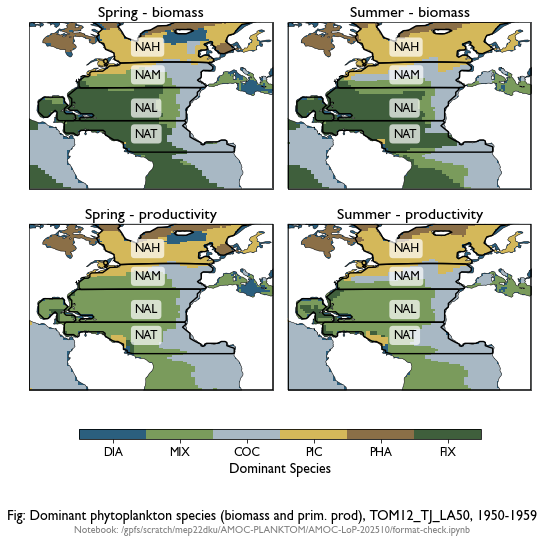

Spring - biomass: min=1.0, max=6.0
Summer - biomass: min=1.0, max=6.0
Spring - productivity: min=1.0, max=6.0
Summer - productivity: min=1.0, max=6.0


In [57]:
# ============ SETTINGS ============
X_MIN = -102
X_MAX = 30
Y_MIN = -20
Y_MAX = 70

FIGURE_WIDTH = 9
FIGURE_HEIGHT = 9
TITLE_FONTSIZE = 16
COLORBAR_LABEL_FONTSIZE = 14
COLORBAR_TICK_FONTSIZE = 12
DESCRIPTION_FONTSIZE = 14
PATH_FONTSIZE = 10
DESCRIPTION_Y_POSITION = 0.1
PATH_Y_POSITION = 0.08
TIGHT_LAYOUT_BOTTOM = 0.06
COLORBAR_PAD = 0.08
REGION_LABEL_FONTSIZE = 12

OUTPUT_DIR = "./plts"
FIG_DESCRIPTION = "Fig: Dominant phytoplankton species (biomass and prim. prod), TOM12_TJ_LA50, 1950-1959"
SHOW_NOTEBOOK_PATH = True
NOTEBOOK_NAME = "format-check.ipynb"
OUTPUT_NAM = 'TOM12_TJ_LA50-dominant_species-GLOBAL.png'

plt.rcParams['text.usetex'] = False
os.makedirs(OUTPUT_DIR, exist_ok=True)
notebook_path = os.path.abspath(os.getcwd())
full_notebook_path = os.path.join(notebook_path, NOTEBOOK_NAME)

# --- Load region mask ---
atl = xr.open_dataset('/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/data/meshmask_with_Atl.nc')
regs = ['NAT', 'NAL', 'NAM', 'NAH']
regdict = {'NAT': 1, 'NAL': 2, 'NAM': 3, 'NAH': 4}

maskno = np.zeros([149, 182])
for reg in regs:
    maskno[atl[reg][0,0,:,:]==1] = regdict[reg]
maskno[maskno==0] = np.nan

# --- Load navigation grid ---
year = 1984
tgrid = xr.open_dataset(f'/gpfs/data/greenocean/software/runs/TOM12_TJ_RVA0/ORCA2_1m_{year}0101_{year}1231_ptrc_T.nc')
nav_lon = tgrid['nav_lon'].values
nav_lat = tgrid['nav_lat'].values

# --- Datasets ---
datasets = [tptrc_spring_rg, tptrc_summer_rg, tdiad_spring_rg, tdiad_summer_rg]
titles = ['Spring - biomass', 'Summer - biomass', 'Spring - productivity', 'Summer - productivity']

# --- Custom colormap ---

cmap = ListedColormap(colors)
bounds = [0.5,1.5,2.5,3.5,4.5,5.5,6.5]
norm = BoundaryNorm(bounds, cmap.N)

# --- Region labels ---
region_labels = [
    {'name':'NAT','lon':-45,'lat':8},
    {'name':'NAL','lon':-45,'lat':22},
    {'name':'NAM','lon':-45,'lat':40},
    {'name':'NAH','lon':-45,'lat':55}
]

# --- Figure and axes ---
fig, axes = plt.subplots(2,2, figsize=(FIGURE_WIDTH,FIGURE_HEIGHT),
                         subplot_kw={'projection':ccrs.PlateCarree()})
axes = axes.flatten()
plt.subplots_adjust(wspace=0.06, hspace=0.15)

for ax, data, title in zip(axes, datasets, titles):
    masked_dominant = data.dominant_species.values
    lon_rg = data.lon.values
    lat_rg = data.lat.values

    im = ax.pcolormesh(lon_rg, lat_rg, masked_dominant,
                       cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

    ax.set_extent([X_MIN, X_MAX, Y_MIN, Y_MAX], crs=ccrs.PlateCarree())

    # Land and coastlines
    ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='none', zorder=3)
    ax.coastlines(zorder=4, linewidth=0.5)

    # Region contours
    for region_num in [1,2,3,4]:
        mask_single = np.where(maskno==region_num,1,0)
        ax.contour(nav_lon, nav_lat, mask_single, levels=[0.5],
                   colors='k', linewidths=1.4, transform=ccrs.PlateCarree(), zorder=3)

    # Region labels
    for reg in region_labels:
        ax.text(reg['lon'], reg['lat'], s=reg['name'], color='k',
                fontsize=REGION_LABEL_FONTSIZE, fontweight='bold',
                transform=ccrs.PlateCarree(), zorder=4,
                bbox=dict(boxstyle='round,pad=0.3',facecolor='white',alpha=0.7,edgecolor='none'))

    # Title
    ax.set_title(title, fontsize=TITLE_FONTSIZE)

    # --- Black border using Rectangle ---
    from matplotlib.patches import Rectangle
    rect = Rectangle((X_MIN,Y_MIN), X_MAX-X_MIN, Y_MAX-Y_MIN,
                     fill=False, color='black', linewidth=1.5,
                     transform=ccrs.PlateCarree(), zorder=10)
    ax.add_patch(rect)

# --- Colorbar ---
cbar = fig.colorbar(im, ax=axes, orientation='horizontal', pad=COLORBAR_PAD, aspect=40, shrink=0.8)
cbar.set_ticks([1,2,3,4,5,6])
cbar.set_ticklabels(['DIA','MIX','COC','PIC','PHA','FIX'])
cbar.ax.tick_params(labelsize=COLORBAR_TICK_FONTSIZE)
cbar.set_label('Dominant Species', fontsize=COLORBAR_LABEL_FONTSIZE)

# --- Description and path ---
fig.text(0.5, DESCRIPTION_Y_POSITION, FIG_DESCRIPTION, ha='center', fontsize=DESCRIPTION_FONTSIZE, style='italic')
if SHOW_NOTEBOOK_PATH:
    fig.text(0.5, PATH_Y_POSITION, f'Notebook: {full_notebook_path}', ha='center',
             fontsize=PATH_FONTSIZE, style='italic', color='gray')

# --- Save ---
os.makedirs(OUTPUT_DIR, exist_ok=True)
output_path = os.path.join(OUTPUT_DIR, OUTPUT_NAM)
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()

# --- Print min/max ---
for title, data in zip(titles, datasets):
    masked = data.dominant_species
    print(f'{title}: min={np.nanmin(masked.values)}, max={np.nanmax(masked.values)}')


## wanky one-plot demo

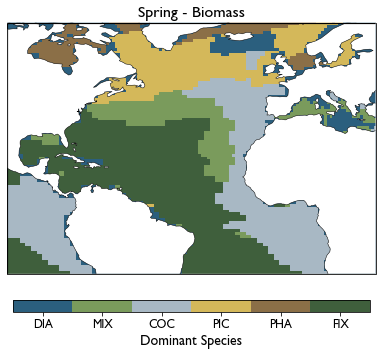

In [58]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Rectangle

# ==== SETTINGS ====
X_MIN, X_MAX = -102, 30
Y_MIN, Y_MAX = -20, 70

FIGURE_WIDTH, FIGURE_HEIGHT = 8, 6
TITLE_FONTSIZE = 16
COLORBAR_TICK_FONTSIZE = 12
COLORBAR_LABEL_FONTSIZE = 14
BORDER_LINEWIDTH = 1.2  # thickness of map border

# --- Load example dataset (replace with your regridded data) ---
data = tptrc_spring_rg  # Replace with your spring biomass xarray

lon = data.lon.values
lat = data.lat.values
masked_dominant = data.dominant_species.values

# --- Custom colormap ---
colors = ['#2B5F7E', '#7A9B5C', '#A8B8C4', '#D4B85A', '#8B6F47', '#3F5F3C']
cmap = ListedColormap(colors)
bounds = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]
norm = BoundaryNorm(bounds, cmap.N)

# --- Plot ---
fig, ax = plt.subplots(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT),
                       subplot_kw={'projection': ccrs.PlateCarree()})

im = ax.pcolormesh(lon, lat, masked_dominant,
                   cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

# Map features
ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='none', zorder=3)
ax.coastlines(zorder=4, linewidth=0.5)
ax.set_extent([X_MIN, X_MAX, Y_MIN, Y_MAX], crs=ccrs.PlateCarree())

# Add thin black border around map area
rect = Rectangle((X_MIN, Y_MIN),
                 X_MAX - X_MIN, Y_MAX - Y_MIN,
                 linewidth=BORDER_LINEWIDTH, edgecolor='black',
                 facecolor='none', zorder=10, transform=ccrs.PlateCarree())
ax.add_patch(rect)

# Title
ax.set_title('Spring - Biomass', fontsize=TITLE_FONTSIZE)

# Colorbar (80% width)
cbar = fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.08, aspect=30, shrink=0.8)
cbar.set_ticks([1, 2, 3, 4, 5, 6])
cbar.set_ticklabels(['DIA', 'MIX', 'COC', 'PIC', 'PHA', 'FIX'])
cbar.ax.tick_params(labelsize=COLORBAR_TICK_FONTSIZE)
cbar.set_label('Dominant Species', fontsize=COLORBAR_LABEL_FONTSIZE)

output_path = os.path.join(OUTPUT_DIR, 'test.png')
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()

## calculate mean productivity and make stacked bar plots

In [59]:
tmesh['csize'] = tmesh['e1t'] * tmesh['e2t'] * tmesh['tmaskutil']

provinces = ['NAT', 'NAL', 'NAH', 'NAM']
variables = ['PPT_DIA', 'PPT_MIX', 'PPT_COC', 'PPT_PIC', 'PPT_PHA', 'PPT_FIX']
variables2 = ['DIA', 'MIX', 'COC', 'PIC', 'PHA', 'FIX']

# Function to compute area-weighted means
def compute_province_means(dataset, tmesh, provinces, variables):
    results = {}
    
    for prov in provinces:
        # Get the mask for this province from tmesh
        prov_mask = tmesh[prov]
        
        # If mask has z dimension and you want z=0, select it
        if 'z' in prov_mask.dims:
            prov_mask = prov_mask.isel(z=0)
        
        # Create weighted mask: area * binary mask
        weighted_mask = tmesh.csize * prov_mask
        
        # Apply area-weighted mean to specified variables
        prov_means = {}
        for var in variables:
            # Weighted mean: sum(data * weights) / sum(weights)
            weighted_data = dataset[var] * weighted_mask
            prov_means[var] = weighted_data.sum(dim=['y', 'x']) / weighted_mask.sum(dim=['y', 'x'])
        
        results[prov] = xr.Dataset(prov_means)
    
    # Combine all provinces into one dataset
    combined = xr.concat([results[prov] for prov in provinces], 
                         dim=xr.DataArray(provinces, dims='province', name='province'))
    
    # Drop singleton t dimension if it exists
    if 't' in combined.dims and combined.sizes['t'] == 1:
        combined = combined.squeeze('t')
    
    return combined

# Compute for all 4 datasets
tptrc_spring_mean = compute_province_means(tptrc_spring_int, tmesh, provinces, variables2)
tptrc_summer_mean = compute_province_means(tptrc_summer_int, tmesh, provinces, variables2)
tdiad_spring_mean = compute_province_means(tdiad_spring_int, tmesh, provinces, variables)
tdiad_summer_mean = compute_province_means(tdiad_summer_int, tmesh, provinces, variables)

## one-season bar plot

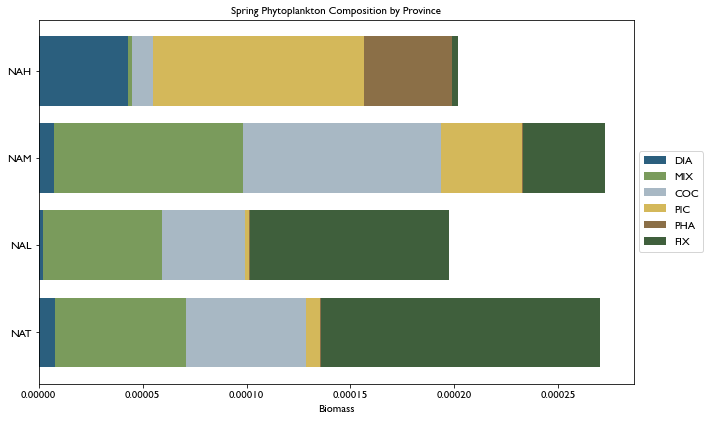

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# Define variables and provinces
variables2 = ['DIA', 'MIX', 'COC', 'PIC', 'PHA', 'FIX']
provinces_ordered = ['NAH', 'NAM', 'NAL', 'NAT']  # Top to bottom

# Assuming you have a colors list/dict for each phytoplankton type
# colors = ['#color1', '#color2', ...]  # 6 colors for the 6 types

fig, ax = plt.subplots(figsize=(10, 6))

# Prepare data - raw magnitudes
data = np.zeros((len(provinces_ordered), len(variables2)))
for i, prov in enumerate(provinces_ordered):
    for j, var in enumerate(variables2):
        data[i, j] = tptrc_spring_mean[f'{var}'].sel(province=prov).values

# Create stacked horizontal bar chart with reversed y-axis
left = np.zeros(len(provinces_ordered))
y_positions = np.arange(len(provinces_ordered))[::-1]  # Reverse the positions

for j, var in enumerate(variables2):
    ax.barh(y_positions, data[:, j], left=left, 
            label=var, color=colors[j])
    left += data[:, j]

ax.set_yticks(y_positions)
ax.set_yticklabels(provinces_ordered)
ax.set_xlabel('Biomass')
ax.set_title('Spring Phytoplankton Composition by Province')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

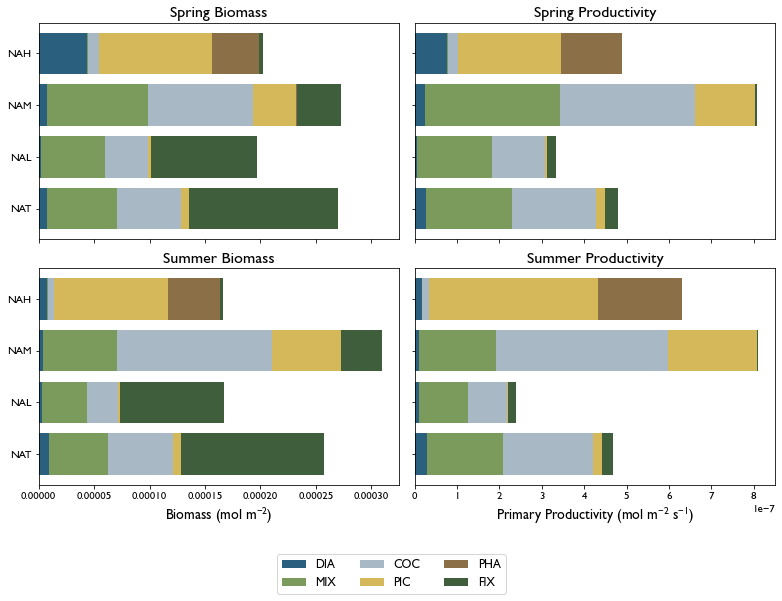

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# Define variables and provinces
variables2 = ['DIA', 'MIX', 'COC', 'PIC', 'PHA', 'FIX']
provinces_ordered = ['NAH', 'NAM', 'NAL', 'NAT']  # Top to bottom

# Assuming you have a colors list/dict for each phytoplankton type
# colors = ['#color1', '#color2', ...]  # 6 colors for the 6 types

# Adjustable figure size
fig_width = 11
fig_height = 8

fig, axes = plt.subplots(2, 2, figsize=(fig_width, fig_height), sharex='col', sharey='row')

# Datasets and titles
datasets = [
    [tptrc_spring_mean, tdiad_spring_mean],
    [tptrc_summer_mean, tdiad_summer_mean]
]
titles = [
    ['Spring Biomass', 'Spring Productivity'],
    ['Summer Biomass', 'Summer Productivity']
]

for row in range(2):
    for col in range(2):
        ax = axes[row, col]
        dataset = datasets[row][col]
        title = titles[row][col]
        
        # Use PPT_ prefix for tdiad datasets (col == 1), no prefix for tptrc (col == 0)
        prefix = 'PPT_' if col == 1 else ''
        
        # Prepare data - raw magnitudes
        data = np.zeros((len(provinces_ordered), len(variables2)))
        for i, prov in enumerate(provinces_ordered):
            for j, var in enumerate(variables2):
                data[i, j] = dataset[f'{prefix}{var}'].sel(province=prov).values
        
        # Create stacked horizontal bar chart with reversed y-axis
        left = np.zeros(len(provinces_ordered))
        y_positions = np.arange(len(provinces_ordered))[::-1]  # Reverse the positions
        
        for j, var in enumerate(variables2):
            ax.barh(y_positions, data[:, j], left=left, 
                    label=var, color=colors[j])
            left += data[:, j]
        
        ax.set_yticks(y_positions)
        ax.set_yticklabels(provinces_ordered)
        ax.set_title(title, fontsize=16)
        
        # Set x-labels based on column (only on bottom row)
        if row == 1:
            if col == 0:
                ax.set_xlabel('Biomass (mol m$^{-2}$)', fontsize=14)
            else:
                ax.set_xlabel('Primary Productivity (mol m$^{-2}$ s$^{-1}$)', fontsize=14)

# Add legend below the subplots in 2 rows
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, 
          fontsize=12, bbox_to_anchor=(0.5, -0.05))

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make room for legend
plt.show()